# Softmax regression on MNIST
Each pixel is employed as individual feature.

In [18]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
import numpy as np
import random
import torch
import time
import os

### Settings

In [19]:
base_dir = '/nfs/team292/kt22/misc/nn_course/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Load datasets

In [20]:
batch_size = 300

# -- Download MNIST dataset
train_dataset = datasets.MNIST(root = os.path.join(base_dir, 'data/MNIST'),
                               train = True,
                               transform = transforms.ToTensor(),
                               download = True)

test_dataset = datasets.MNIST(root = os.path.join(base_dir, 'data/MNIST'),
                              train = False, 
                              transform = transforms.ToTensor(),
                              download = True)

# -- Load MNIST dataset
train_loader = DataLoader(dataset = train_dataset, 
                          batch_size = batch_size, 
                          shuffle = True)

test_loader = DataLoader(dataset = test_dataset, 
                         batch_size = batch_size, 
                         shuffle = False)

# -- Checking dataset dimensions
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape) #NCHW
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([200, 1, 28, 28])
Image label dimensions: torch.Size([200])


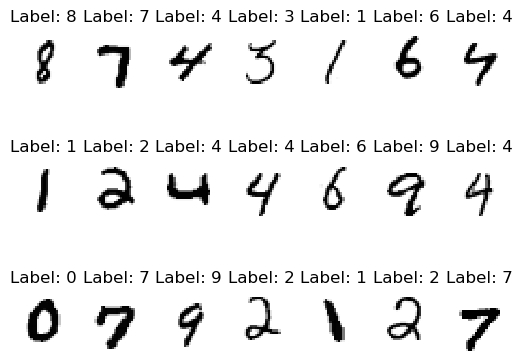

In [21]:
rnd_idx = [ random.randint(0, len(train_loader.dataset)) for p in range(0, 21) ]

fig, axs = plt.subplots(ncols = 7, nrows = 3)

for rnd, ax in zip(rnd_idx, axs.T.ravel()):
    
    sns.heatmap(train_loader.dataset[rnd][0].numpy()[0],
                cmap = 'Greys',
                cbar = False,
                ax = ax,
                square = True,
                xticklabels = False,
                yticklabels = False) \
                .set(title=  'Label: ' + str(train_loader.dataset[rnd][1]),
                        xticklabels = '',
                        yticklabels = '')

### Define SofMax model

In [22]:
class SofmaxRegression(torch.nn.Module):
    
    def __init__(self, num_features, num_classes):
        super(SofmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(in_features = num_features,
                                      out_features = num_classes)
        # Set weight and bias to zero
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim = 1)
        return logits, probas


Instantiate the model and the optimizer

In [23]:
# -- Num features correspond to the dimensions of the images
model = SofmaxRegression(num_features = 28 * 28,
                         num_classes = 10)
model.to(device)

# -- constructs an optimizer object, that will hold the current
# -- state and will update the parameters based on the computed gradients.
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.1)

In [24]:
torch.manual_seed(42)

def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.view(-1, 28 * 28).to(device)
        targets = targets.to(device)
        # -- Execute model
        logits, probas = model(features)
        max_prob , predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100

### Run network

In [25]:
num_epochs = 15

In [26]:
start_time = time.time()
epoch_costs = []

for epoch in range(num_epochs):
    avg_cost = 0.
    
    for batch_idx, (features, targets) in enumerate(train_loader):

        # -- Converts feature matrix to vector
        features = features.view(-1, 28 * 28).to(device)
        targets = targets.to(device)
            
        # -- FORWARD AND BACK PROP
        # -- initially will be 0 as weights and bias are 0
        logits, probas = model(features)
        
        # note that the PyTorch implementation of
        # CrossEntropyLoss works with logits,
        # not probabilities
        cost = F.cross_entropy(logits, targets)
        # -- For every batch in training we set the grandients to
        # -- zero before backpropagation. This avoids the gradient
        # -- to be a combination of the previous.
        optimizer.zero_grad()
        cost.backward()
        avg_cost += cost
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        # If divisible by 50
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))
            
    with torch.set_grad_enabled(False):

        avg_cost = avg_cost/len(train_dataset)
        epoch_costs.append(avg_cost)
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/300 | Cost: 2.3026
Epoch: 001/010 | Batch 050/300 | Cost: 0.8685
Epoch: 001/010 | Batch 100/300 | Cost: 0.6251
Epoch: 001/010 | Batch 150/300 | Cost: 0.4753
Epoch: 001/010 | Batch 200/300 | Cost: 0.4923
Epoch: 001/010 | Batch 250/300 | Cost: 0.4827
Epoch: 001/010 training accuracy: 88.53%
Time elapsed: 0.30 min
Epoch: 002/010 | Batch 000/300 | Cost: 0.4338
Epoch: 002/010 | Batch 050/300 | Cost: 0.4022
Epoch: 002/010 | Batch 100/300 | Cost: 0.4355
Epoch: 002/010 | Batch 150/300 | Cost: 0.3674
Epoch: 002/010 | Batch 200/300 | Cost: 0.4301
Epoch: 002/010 | Batch 250/300 | Cost: 0.3802
Epoch: 002/010 training accuracy: 89.61%
Time elapsed: 0.62 min
Epoch: 003/010 | Batch 000/300 | Cost: 0.3345
Epoch: 003/010 | Batch 050/300 | Cost: 0.3789
Epoch: 003/010 | Batch 100/300 | Cost: 0.3899
Epoch: 003/010 | Batch 150/300 | Cost: 0.3505
Epoch: 003/010 | Batch 200/300 | Cost: 0.3170
Epoch: 003/010 | Batch 250/300 | Cost: 0.3687
Epoch: 003/010 training accuracy: 90.30%
Tim